# Pet breed classification

This is an experiment building an image classifier using transfer learning, with a
forward-forward network for the classifier head. Using Mobilnet_v2 to do feature 
extraction from lareger/color images, and then feed the resulting latent images through
the FF network.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from layers import FFDense
from img_classifier import ImageClassifier
import utils


c:\Users\karen\myprojects\forward-forward\fwd-fwd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download the pretrained CNN (Mobilenet_v2)

In [2]:
module_selection = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

extract_layer = hub.KerasLayer(MODULE_HANDLE,
                              input_shape=IMAGE_SIZE + (3,), 
                              output_shape=[FV_SIZE],
                              trainable=False)
     
extractor = Sequential([extract_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Collect data

In [3]:
(raw_train, raw_test), metadata = tfds.load('OxfordIIITPet',
                                            split=['train', 'test'],
                                            with_info=True,
                                            as_supervised=True)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE)

Look at a sample of the images

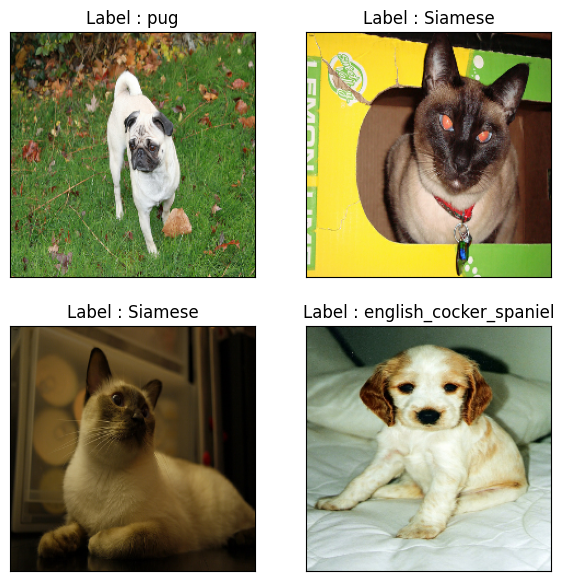

In [4]:
ds = raw_train.take(100)
imgs = []
labels = []
for image, label in tfds.as_numpy(ds):
  image = tf.image.resize(image, (224, 224)) / 255.0
  imgs.append(image)
  labels.append(label)
imgs = np.array(imgs)
labels = np.array(labels)

utils.show_samples(imgs, labels, class_names)

## Train our classifier

In [8]:
clf = ImageClassifier(extractor, [500, 500, num_classes], len(class_names), learning_rate=0.01, iterations=1)
hist = clf.fit(train_batches, epochs=100)

Epoch 1
115/115[====================] 1 min 36.80 sec - loss: 0.7342
Epoch 2
115/115[====================] 1 min 31.22 sec - loss: 0.7012
Epoch 3
115/115[====================] 1 min 29.65 sec - loss: 0.6946
Epoch 4
115/115[====================] 1 min 30.40 sec - loss: 0.6885
Epoch 5
115/115[====================] 1 min 34.01 sec - loss: 0.6826
Epoch 6
115/115[====================] 1 min 34.05 sec - loss: 0.6772
Epoch 7
115/115[====================] 1 min 34.13 sec - loss: 0.6720
Epoch 8
115/115[====================] 1 min 33.12 sec - loss: 0.6670
Epoch 9
115/115[====================] 1 min 33.76 sec - loss: 0.6622
Epoch 10
115/115[====================] 1 min 35.12 sec - loss: 0.6576
Epoch 11
115/115[====================] 1 min 35.49 sec - loss: 0.6533
Epoch 12
115/115[====================] 1 min 35.52 sec - loss: 0.6490
Epoch 13
115/115[====================] 1 min 36.69 sec - loss: 0.6448
Epoch 14
115/115[====================] 1 min 35.29 sec - loss: 0.6407
Epoch 15
115/115[============

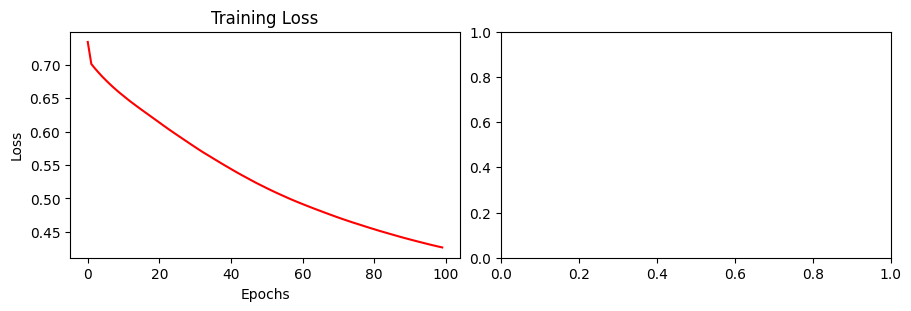

In [9]:
utils.plot_history(hist)

115/115[====================] 16 min 36.07 sec
FF Accuracy = 85.83%


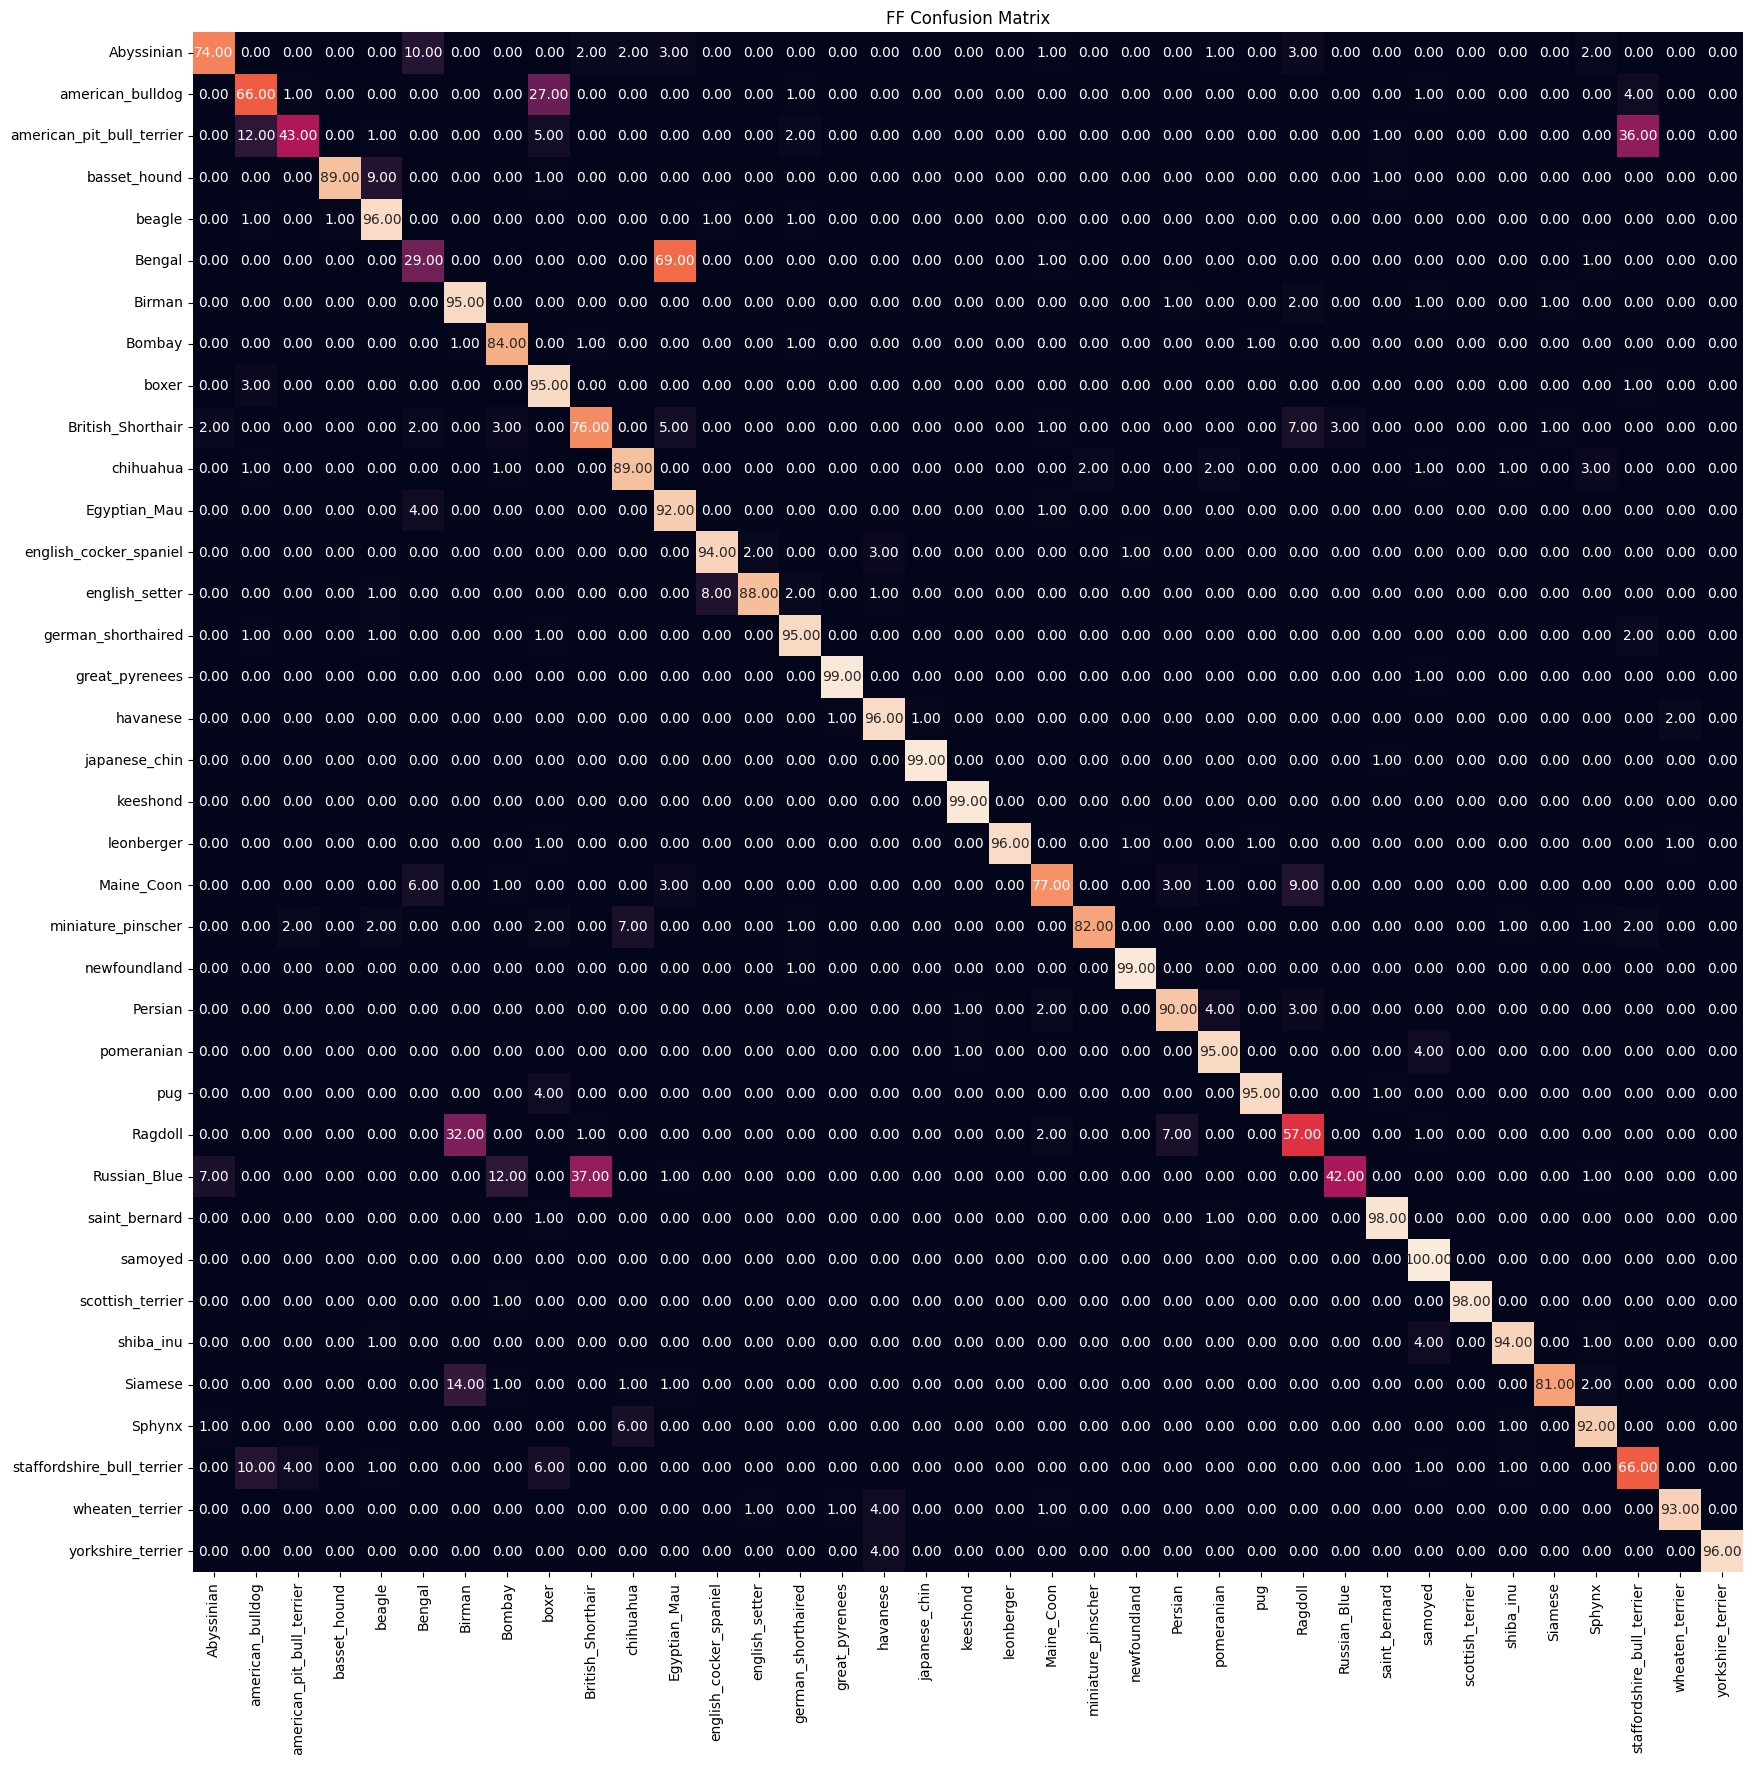

In [10]:
y = [labels.numpy() for _, labels in test_batches]
y = np.concatenate(y)

pred_labels = clf.predict(test_batches)
utils.evaluate(y, pred_labels, class_names, 'FF')


## Comparison with standard transfer learning

In [8]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [10]:
clf_base = Sequential([extractor,
                       Dense(num_classes, activation='softmax')])

clf_base.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
hist = clf_base.fit(train_batches, epochs=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 83s 694ms/step - loss: 0.8356
Epoch 2/10
115/115 [==============================] - 81s 697ms/step - loss: 0.2097
Epoch 3/10
115/115 [==============================] - 81s 697ms/step - loss: 0.0984
Epoch 4/10
115/115 [==============================] - 82s 704ms/step - loss: 0.0456
Epoch 5/10
115/115 [==============================] - 83s 712ms/step - loss: 0.0224
Epoch 6/10
115/115 [==============================] - 81s 698ms/step - loss: 0.0080
Epoch 7/10
115/115 [==============================] - 80s 689ms/step - loss: 0.0031
Epoch 8/10
115/115 [==============================] - 85s 732ms/step - loss: 0.0028
Epoch 9/10
115/115 [==============================] - 80s 688ms/step - loss: 0.0160
Epoch 10/10
115/115 [==============================] - 83s 711ms/step - loss: 0.0356


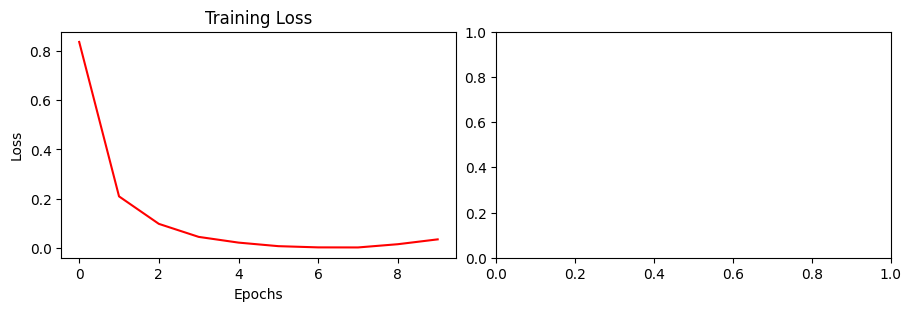

115/115 [==============================] - 70s 606ms/step
Backprop Accuracy = 83.57%


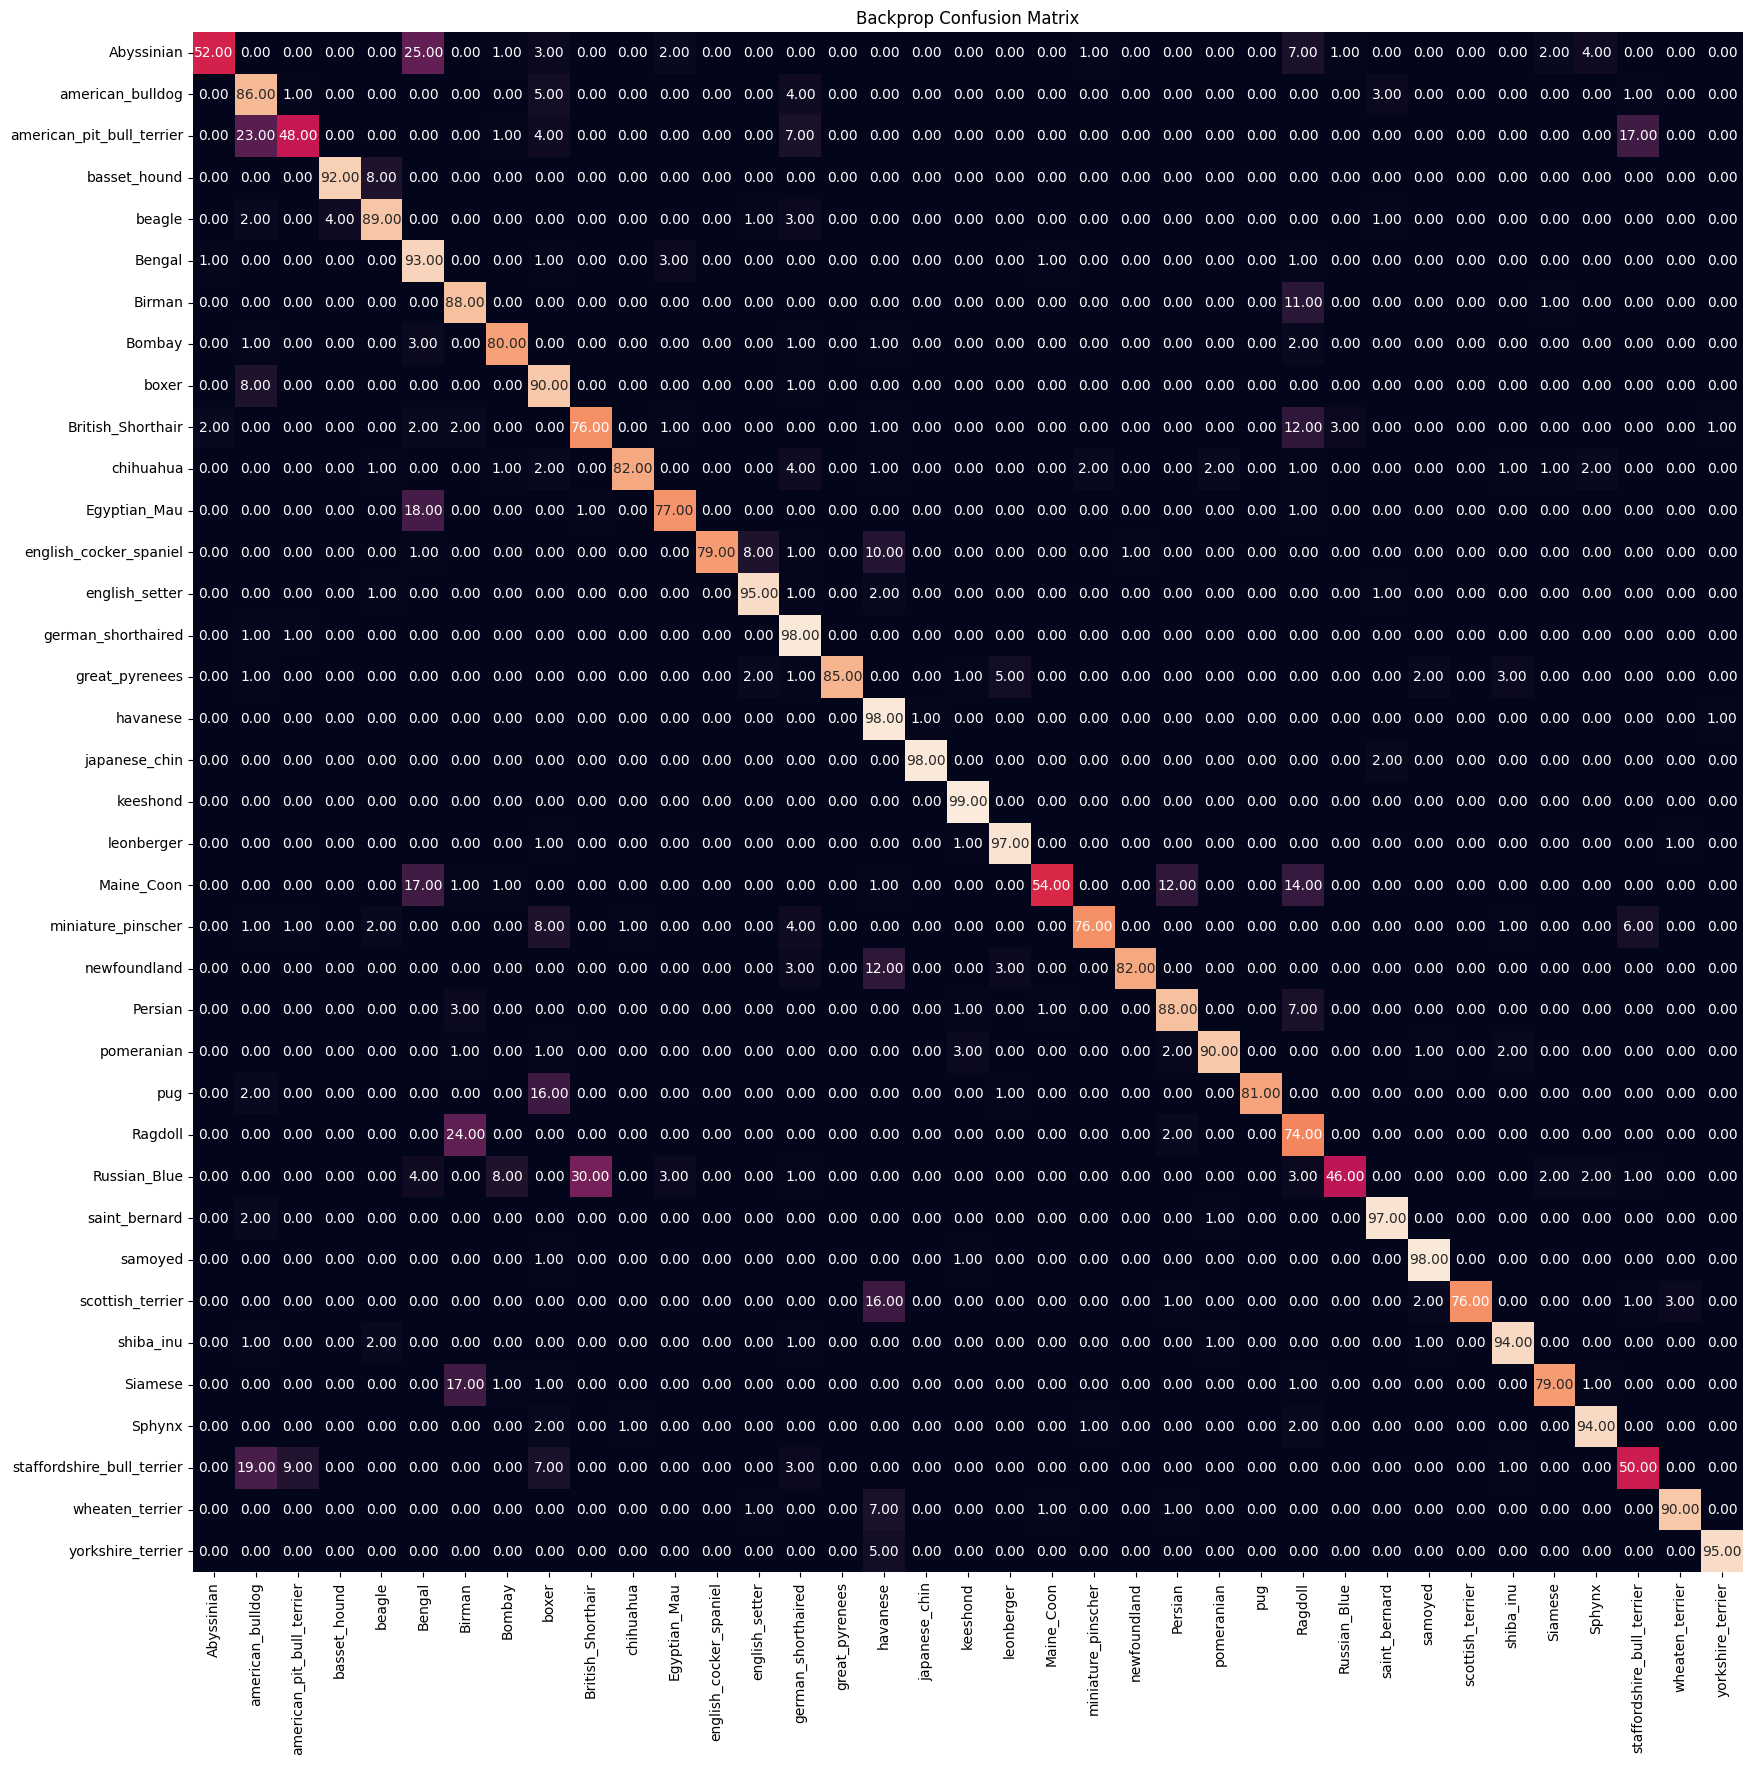

In [18]:
utils.plot_history(hist.history)

pred_labels = clf_base.predict(test_batches, verbose=1)
pred_labels = np.argmax(pred_labels, axis=1)
utils.evaluate(y, pred_labels, class_names, 'Backprop')